In [1]:
from datetime import datetime

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from copy import deepcopy

textwidth = 455.24411 / 72 # inches
golden_ratio = (1 + 5**0.5) / 2
mpl.rcParams['figure.dpi'] = 600
mpl.rcParams['figure.figsize'] = (textwidth, textwidth / golden_ratio)
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.family'] = "Computer Modern Roman"
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['figure.titlesize'] = 12
mpl.rcParams["figure.autolayout"] = True
mpl.rcParams['text.usetex'] = True


import seaborn as sns

import gym
import numpy as np
import pandas as pd
from gym.wrappers import TimeLimit
# from stable_baselines3 import PPO
from sb3_contrib import MaskablePPO
from sb3_contrib.common.maskable.utils import get_action_masks


from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_checker import check_env

# from src.custom_cnn import CustomCNN
from src.custom_policy import CustomActorCriticPolicy, ReshapeExtractor


In [2]:
J = 1.0
U = 2.0
Ne = 8
env_id = "gym_latticemodels:falicovkimball2D-v0"



Use only one from the cells below:

In [3]:
SIDE_LENGTH = 4
env = gym.make(
    env_id,
    L=SIDE_LENGTH,
    Ne=Ne,
    U=U,
)

folder_path = "../results/medusa/falicovkimball_L4"

model = MaskablePPO.load(folder_path + "/model", env=env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [7]:
SIDE_LENGTH = 6
env = gym.make(
    env_id,
    L=SIDE_LENGTH,
    J=J,
)

# folder_path = "../results/medusa/xy_L6"
model = PPO.load(folder_path + "/model", env=env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [21]:
all_energies = [] # list of lists
for i in range(100):
    energies = []
    obs = env.reset()
    lattice_init = deepcopy(env.state)
    energies.append(env.compute_energy())
    for i in range(65):
        action_masks = get_action_masks(env)
        action, _state = model.predict(obs, action_masks=action_masks, deterministic=True)
        obs, reward, done, info = env.step(action)
        energies.append(env.compute_energy())
        if done:
            # print(f"{reward=}")
            # # TODO plot lattice function
            # lattice = env.state_to_lattice()
            # ax = plt.figure().add_subplot()
            # x, y = np.meshgrid(np.arange(SIDE_LENGTH),
            #             np.arange(SIDE_LENGTH))
            # ax.quiver(x, y, np.cos(lattice[0,...]), np.sin(lattice[0,...]))
            # plt.xticks([])
            # plt.yticks([])
            # plt.show()
            break
            # env.reset()
        # if i % 100 == 0:
        #   print(f"{i=}, {reward=}")
        #   env.render()
    all_energies.append(energies)


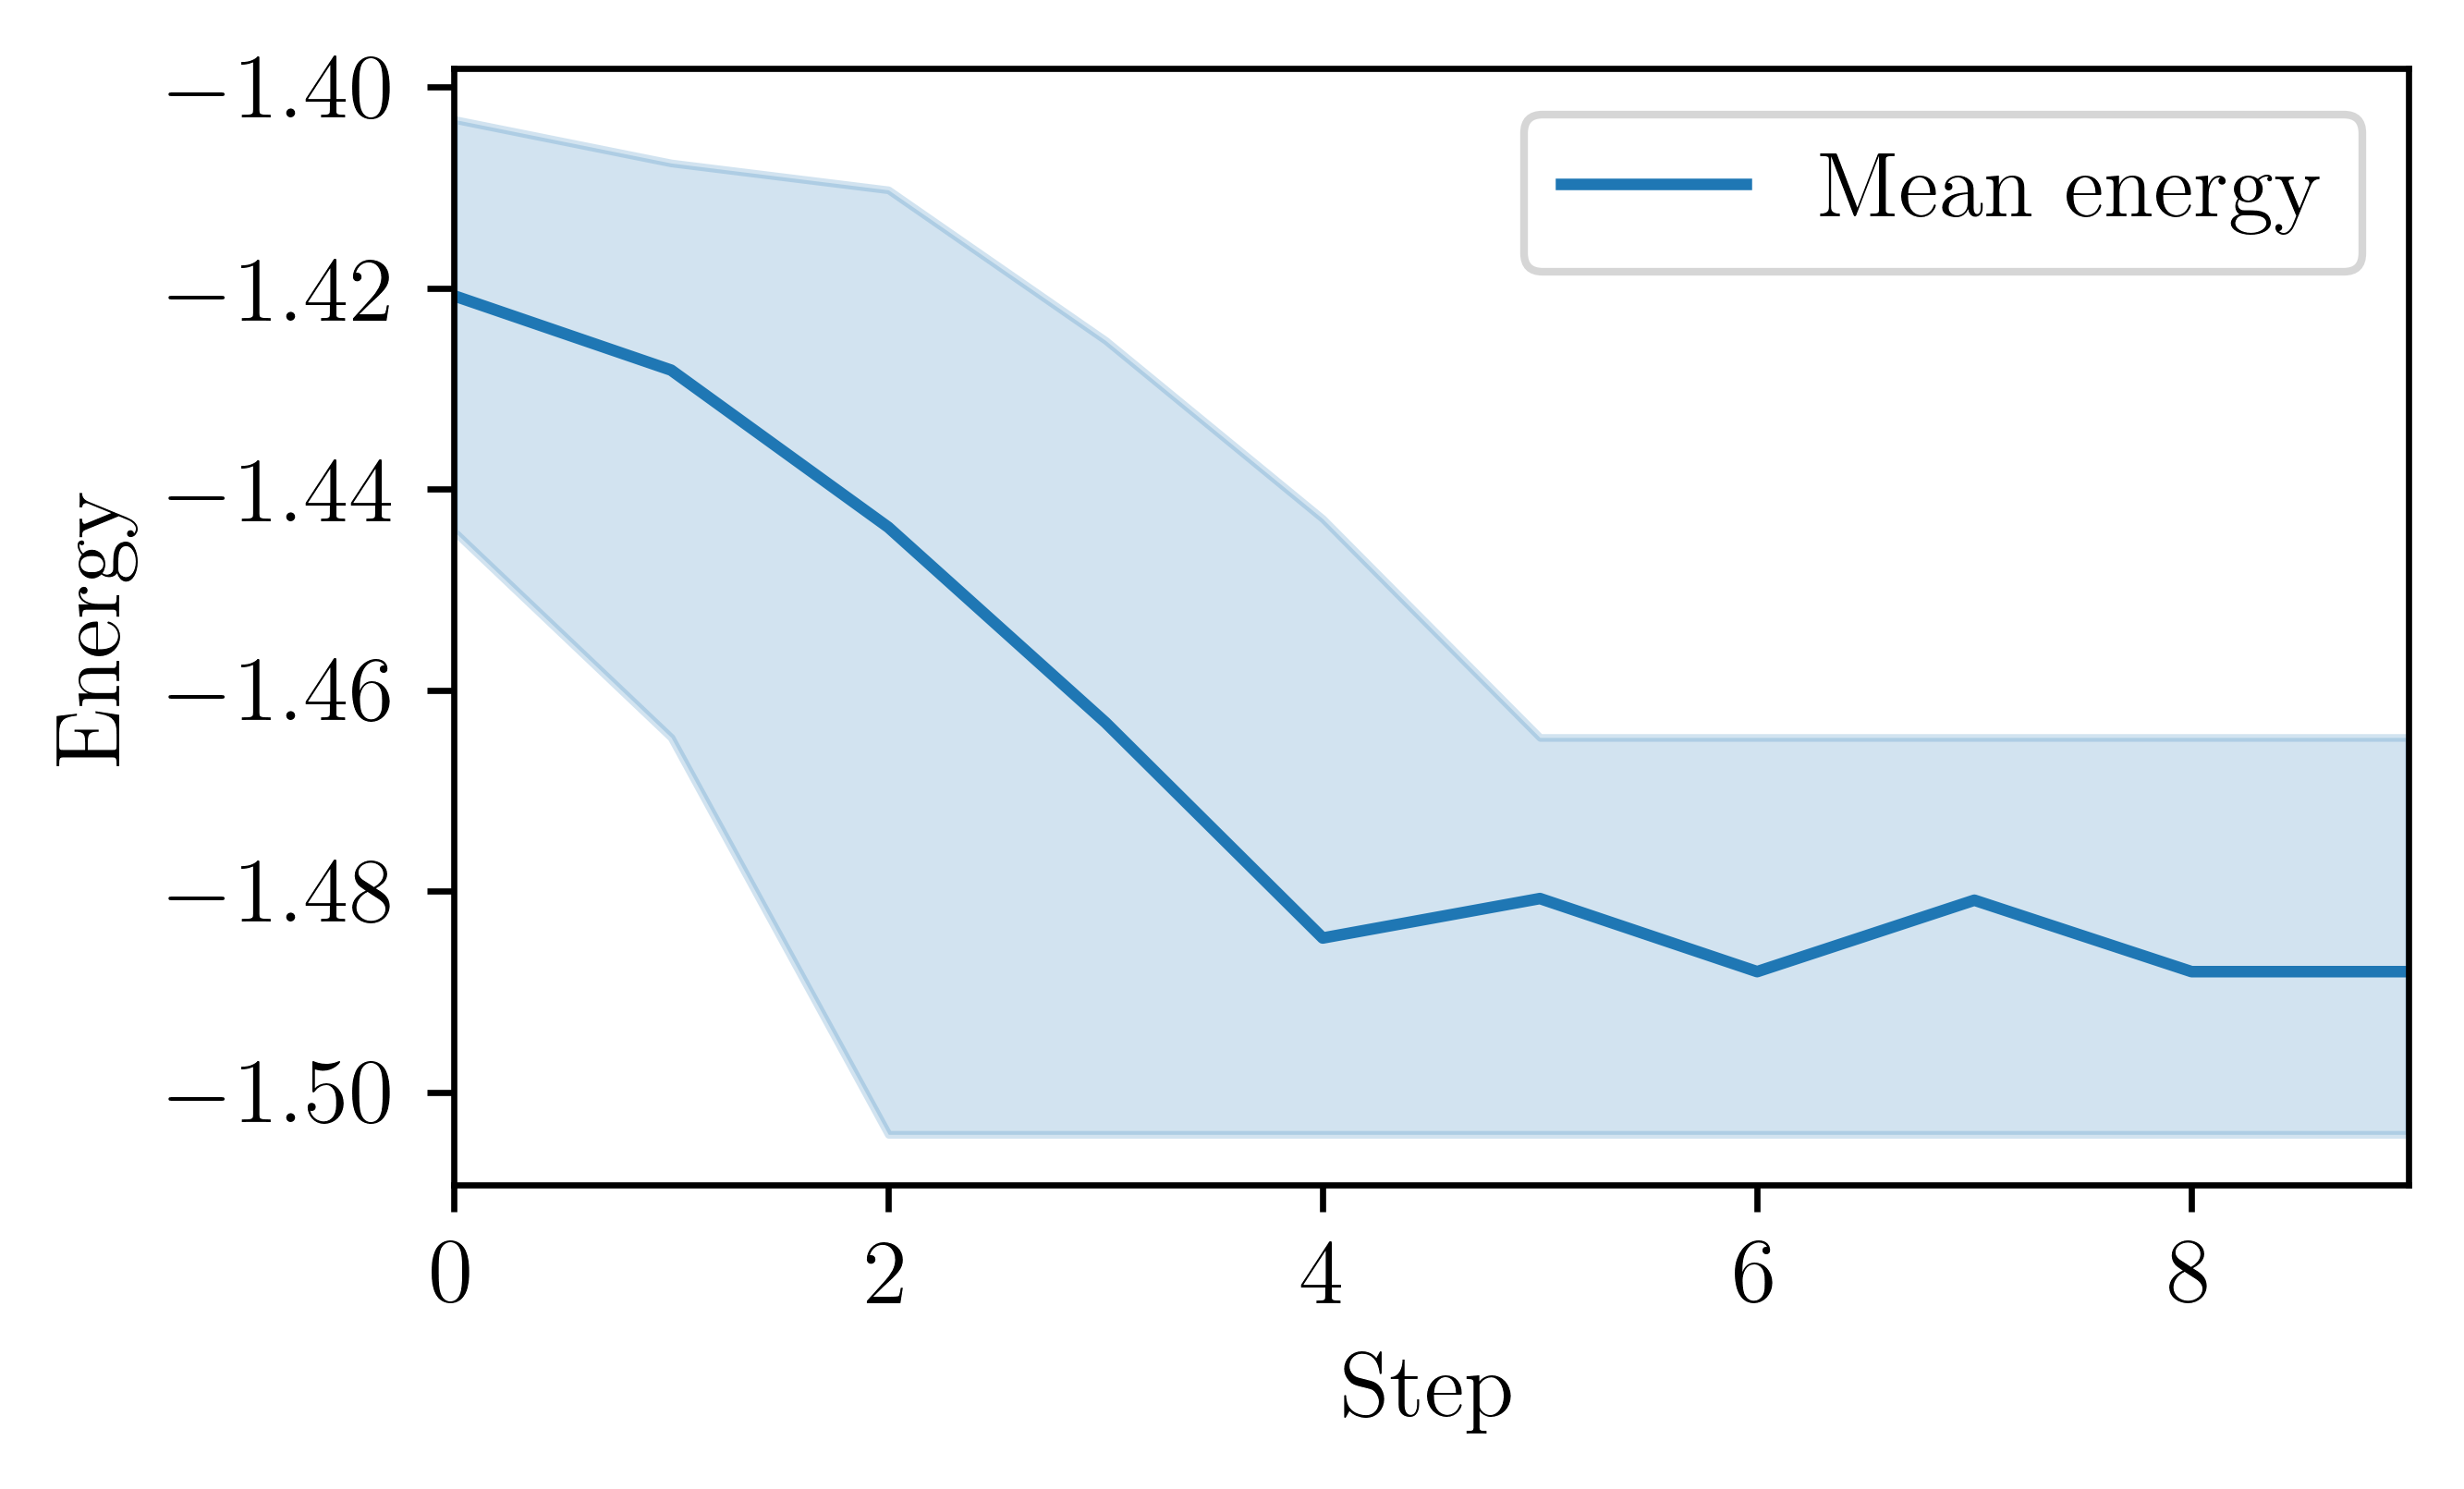

In [73]:

df = pd.DataFrame(all_energies).melt()
fig, ax = plt.subplots(figsize=(0.45 * textwidth * golden_ratio, 0.45 * textwidth))
sns.lineplot(ax=ax, x="variable", y="value", data=df, errorbar=("pi", 95), label="Mean energy") #, ci="sd")
E_lims = ax.get_ylim()
plt.xlim(0, df.variable.max())
# plt.hlines(-2.0, 0, df.variable.max(), linestyles="dashed", colors="gray",
#  label="Exact ground state")
plt.xlabel("Step")
plt.ylabel("Energy")
plt.tight_layout()
plt.legend()
# plt.savefig(f"../results/ising_L{SIDE_LENGTH}_energy.png", dpi=600)
plt.savefig(f"../results/falicovkimball_L{SIDE_LENGTH}_energy.pdf")

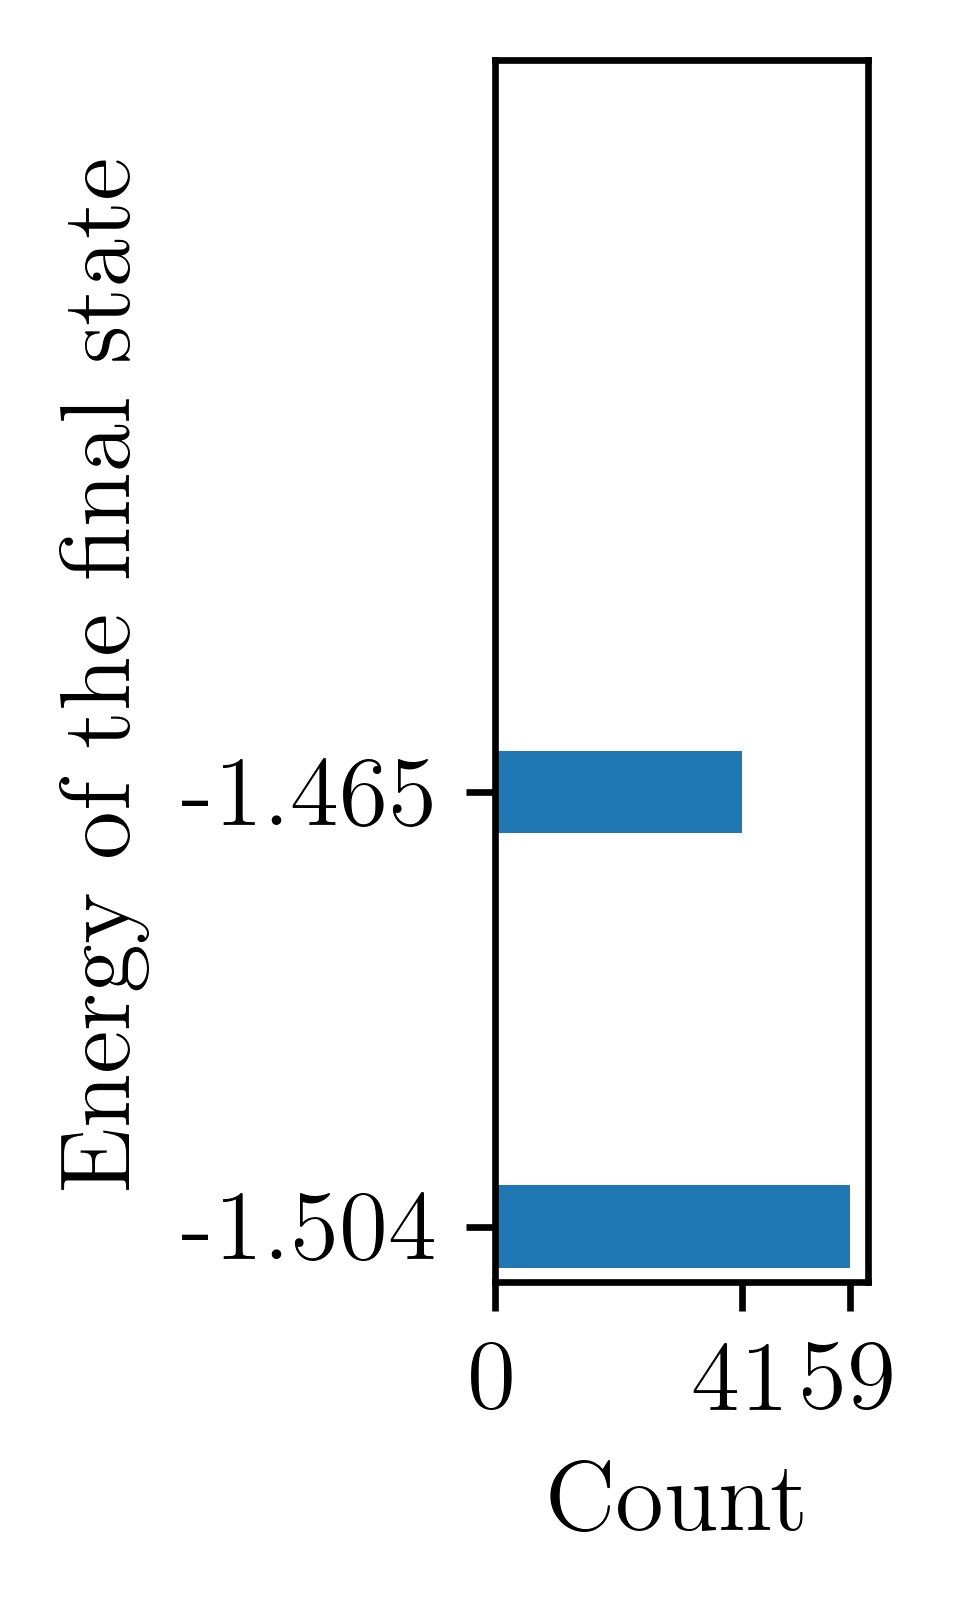

In [74]:
# sns.histplot([energies[-1] for energies in all_energies])
# plt.hist([energies[-1] for energies in all_energies], orientation="horizontal", bins=3, align='mid')
# plt.hist([energies[-1] for energies in all_energies], bins=3, align='mid')
# [energies[-1] for energies in all_energies]
fig, ax = plt.subplots(figsize=(0.45 * textwidth / golden_ratio, 0.45 * textwidth))


last_energies = [energies[-1] for energies in all_energies]
possible_energies = np.unique(last_energies)
last_energies_counts = [last_energies.count(pE) for pE in possible_energies]
plt.barh(possible_energies, last_energies_counts, align='center', height=0.0075)

plt.yticks(np.unique([energies[-1] for energies in all_energies]))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:.3f}"))
plt.ylim(E_lims)

plt.xticks([0] + last_energies_counts)

plt.xlabel("Count")
plt.ylabel("Energy of the final state")

plt.savefig(f"../results/falicovkimball_L{SIDE_LENGTH}_efinalcount.pdf")


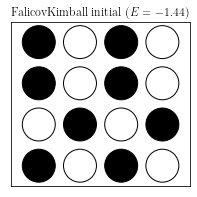

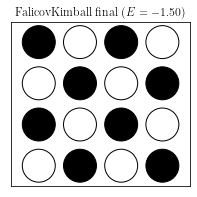

In [20]:
def plot_lattice(lattice):
    # ax = plt.figure().add_subplot()
    fig, ax = plt.subplots(figsize=(0.45*textwidth, 0.45*textwidth))
    x, y = np.meshgrid(np.arange(SIDE_LENGTH),
                np.arange(SIDE_LENGTH))
    ax.axis('equal')
    r = 0.4
    for x1, y1, node in zip(x.flatten(), y.flatten(), lattice):
        color = "black" if node else "white"
        circle = plt.Circle((x1, y1), r, edgecolor="black", facecolor=color, linewidth=1)
        ax.add_patch(circle)





    ax.set(xlim=(-0.5, SIDE_LENGTH - 0.5), ylim=(-0.5, SIDE_LENGTH - 0.5))
    plt.xticks([])
    plt.yticks([])
    return fig, ax

fig, ax = plot_lattice(lattice_init)
ax.set_title(f"FalicovKimball initial $(E={all_energies[-1][0]:.2f})$")
fig.tight_layout()
# plt.savefig(f"../results/ising_L{SIDE_LENGTH}_initial_state.png", dpi=600)
plt.savefig(f"../results/falicovkimball_L{SIDE_LENGTH}_initial_state.pdf")


fig, ax = plot_lattice(env.state)
ax.set_title(f"FalicovKimball final  $(E={all_energies[-1][-1]:.2f})$")
# fig.tight_layout()
# # plt.savefig(f"../results/ising_L{SIDE_LENGTH}_final_state.png", dpi=600)
plt.savefig(f"../results/falicovkimball_L{SIDE_LENGTH}_final_state.pdf")



plt.show()



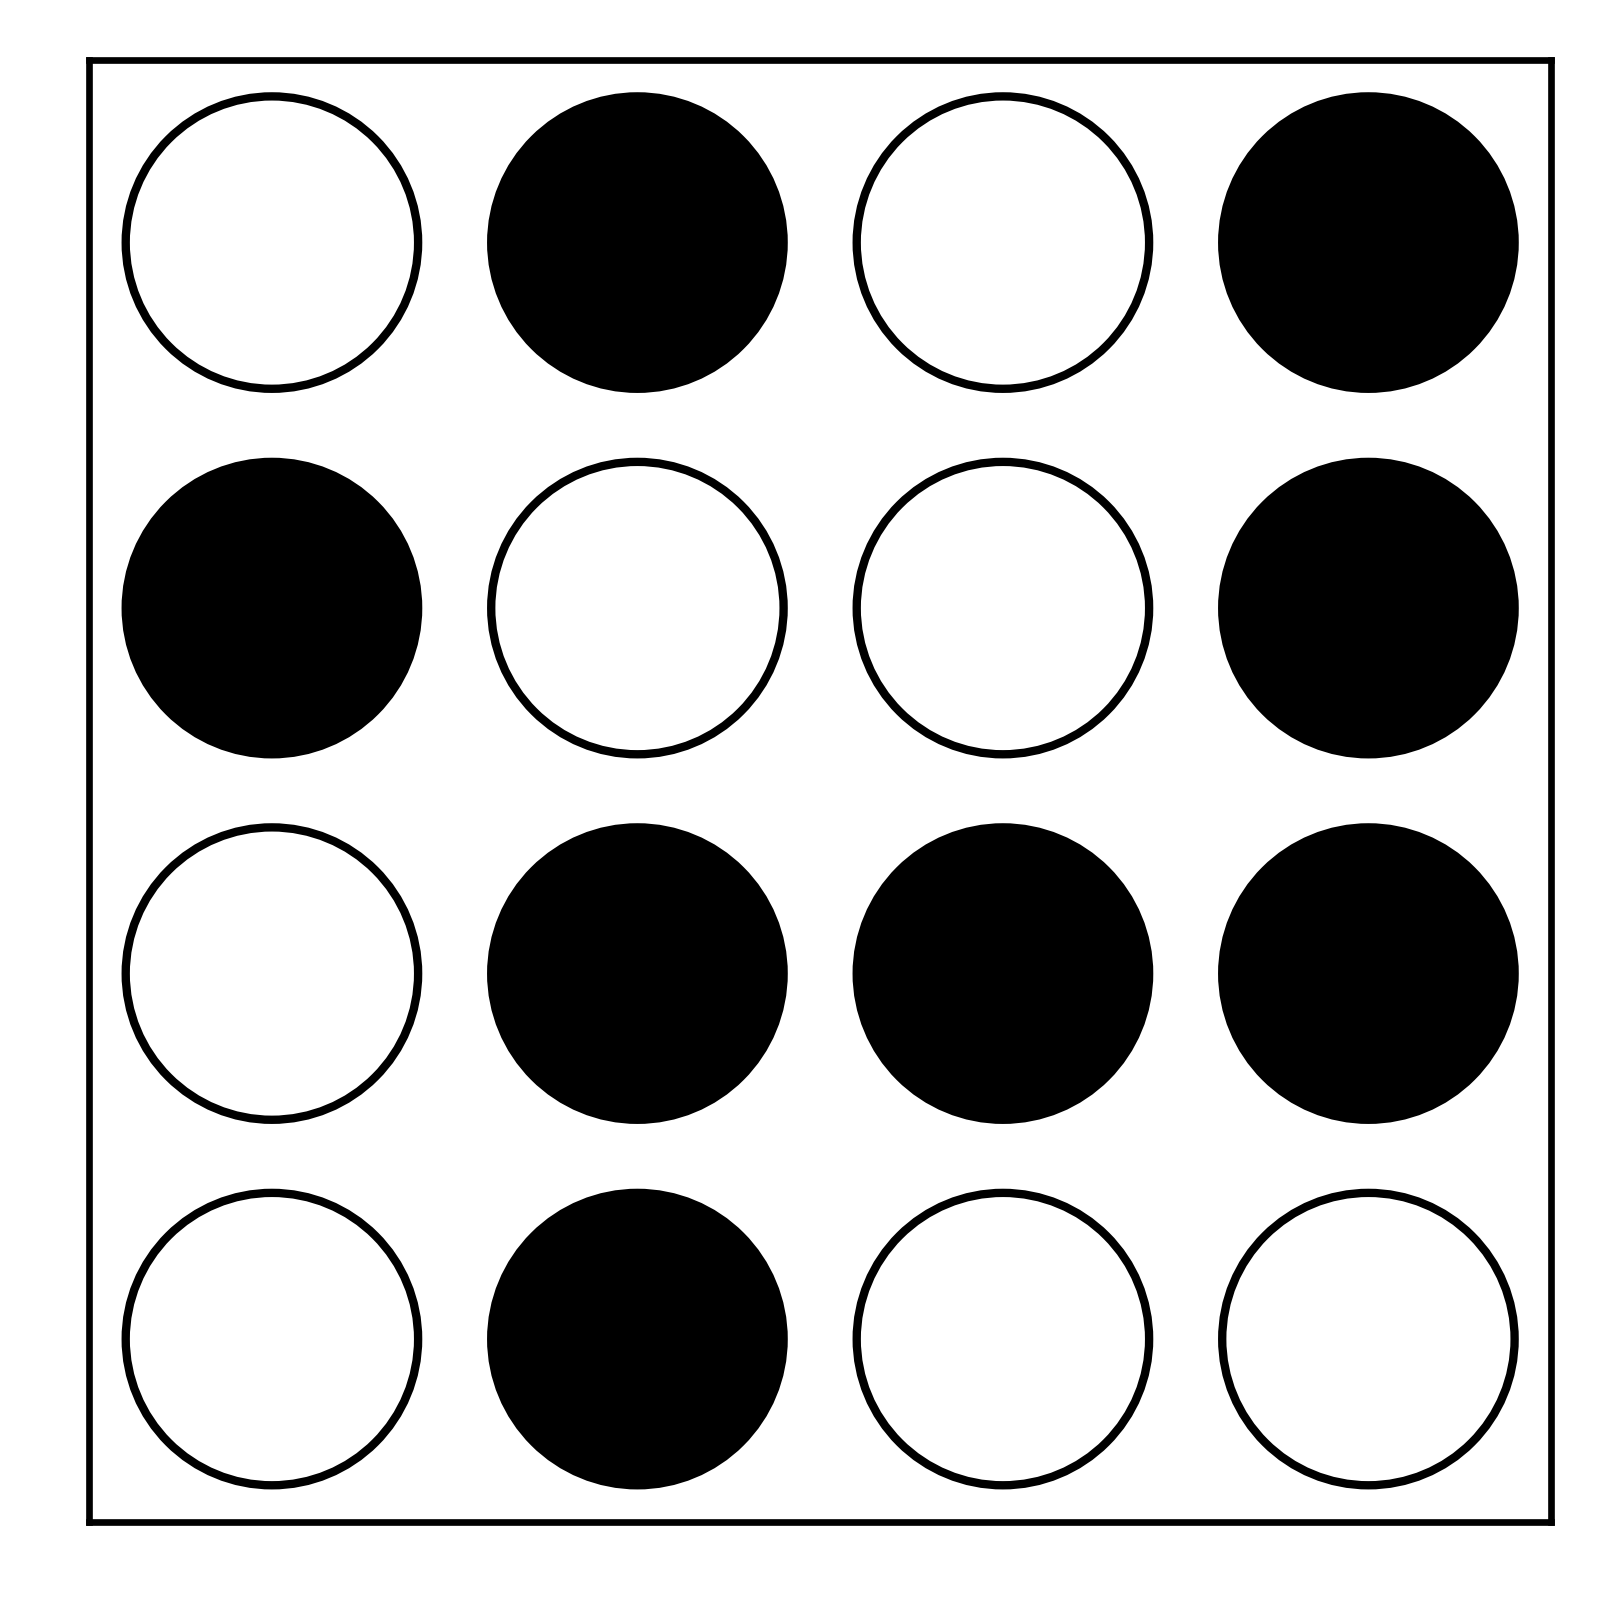

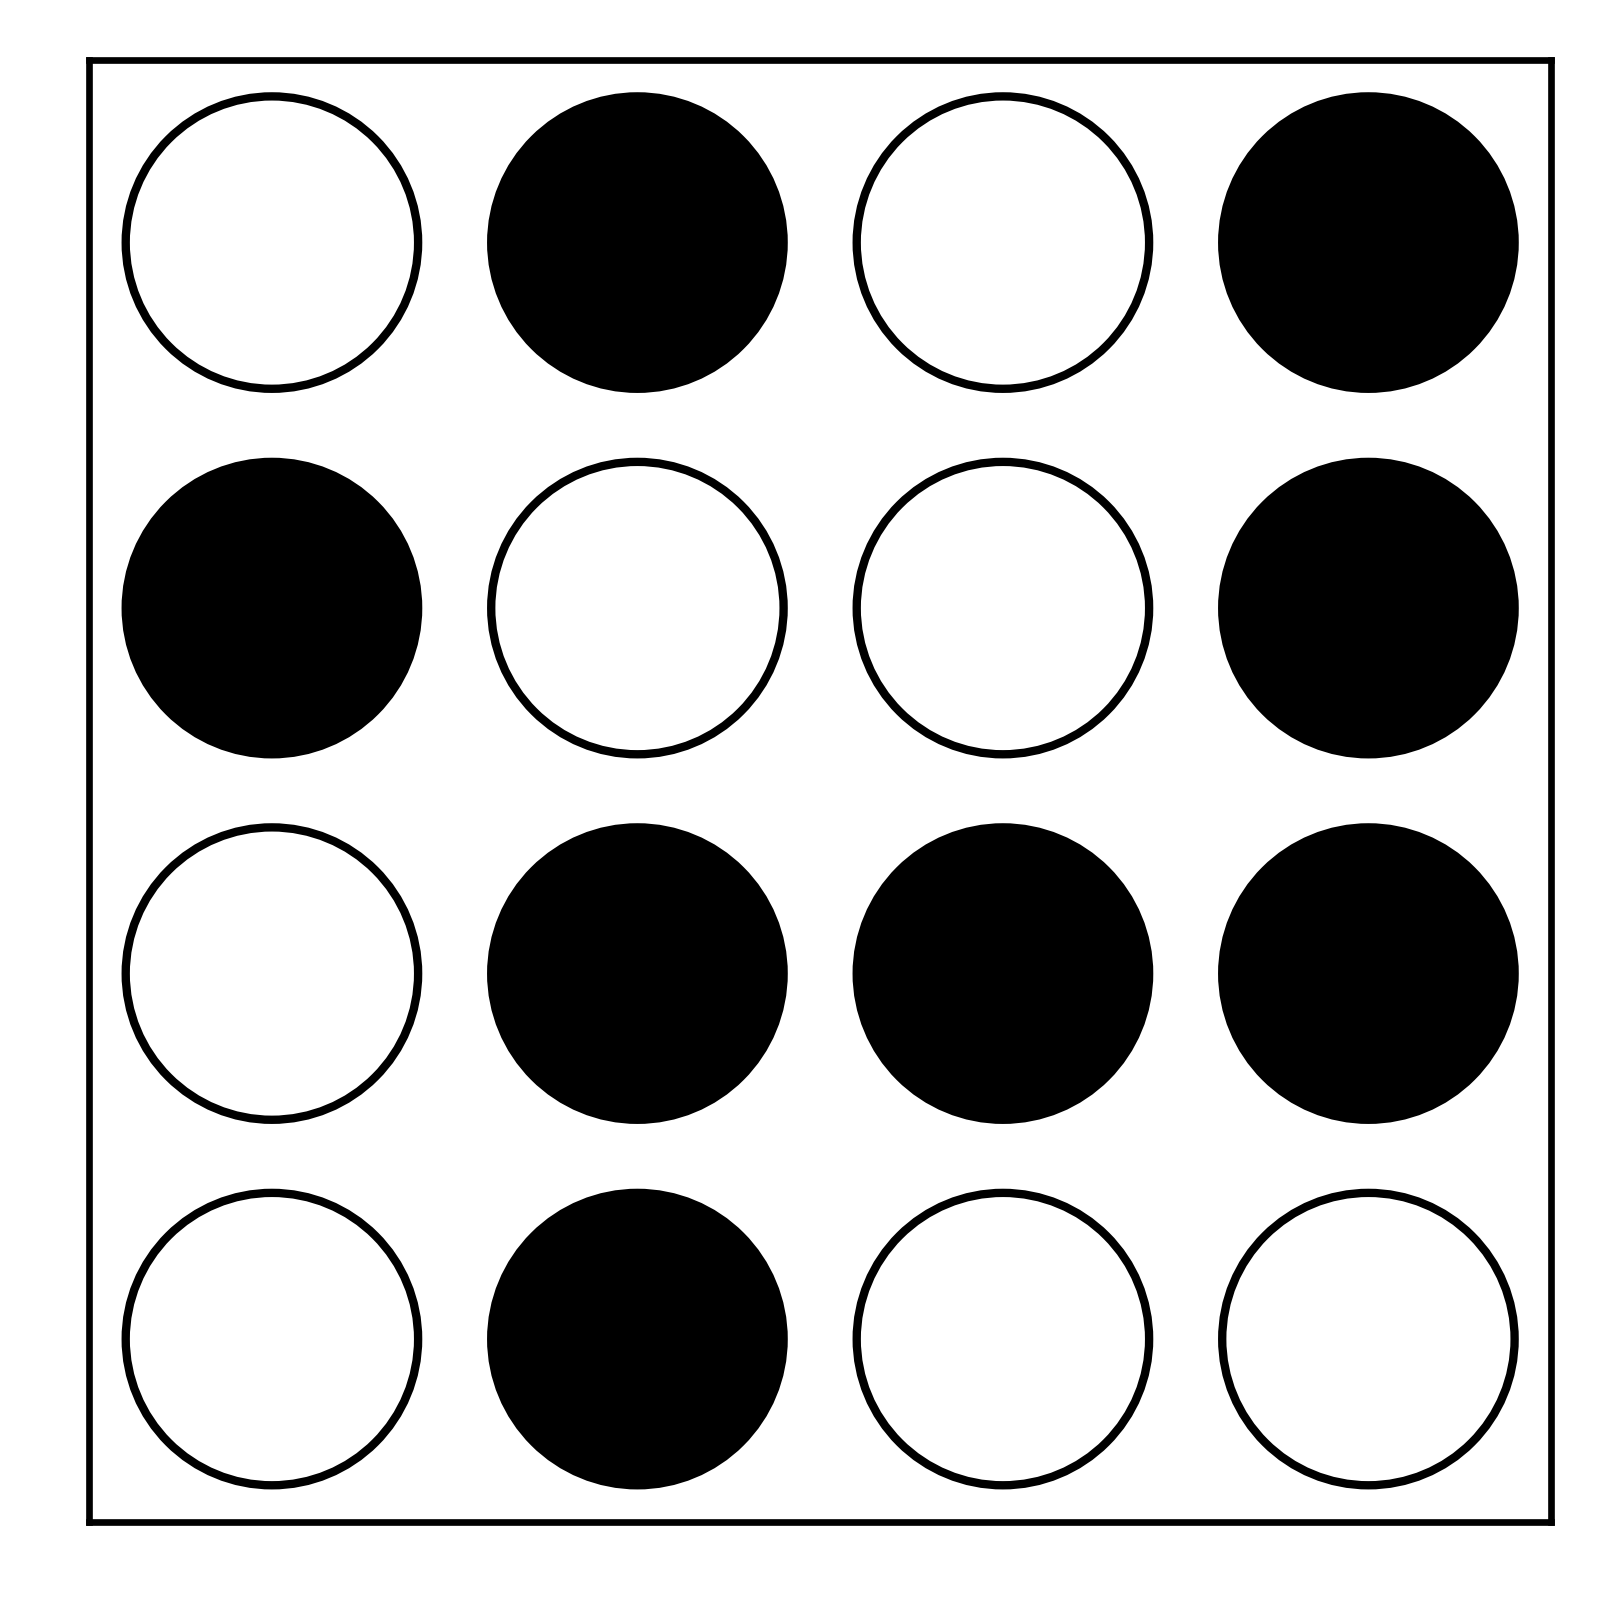

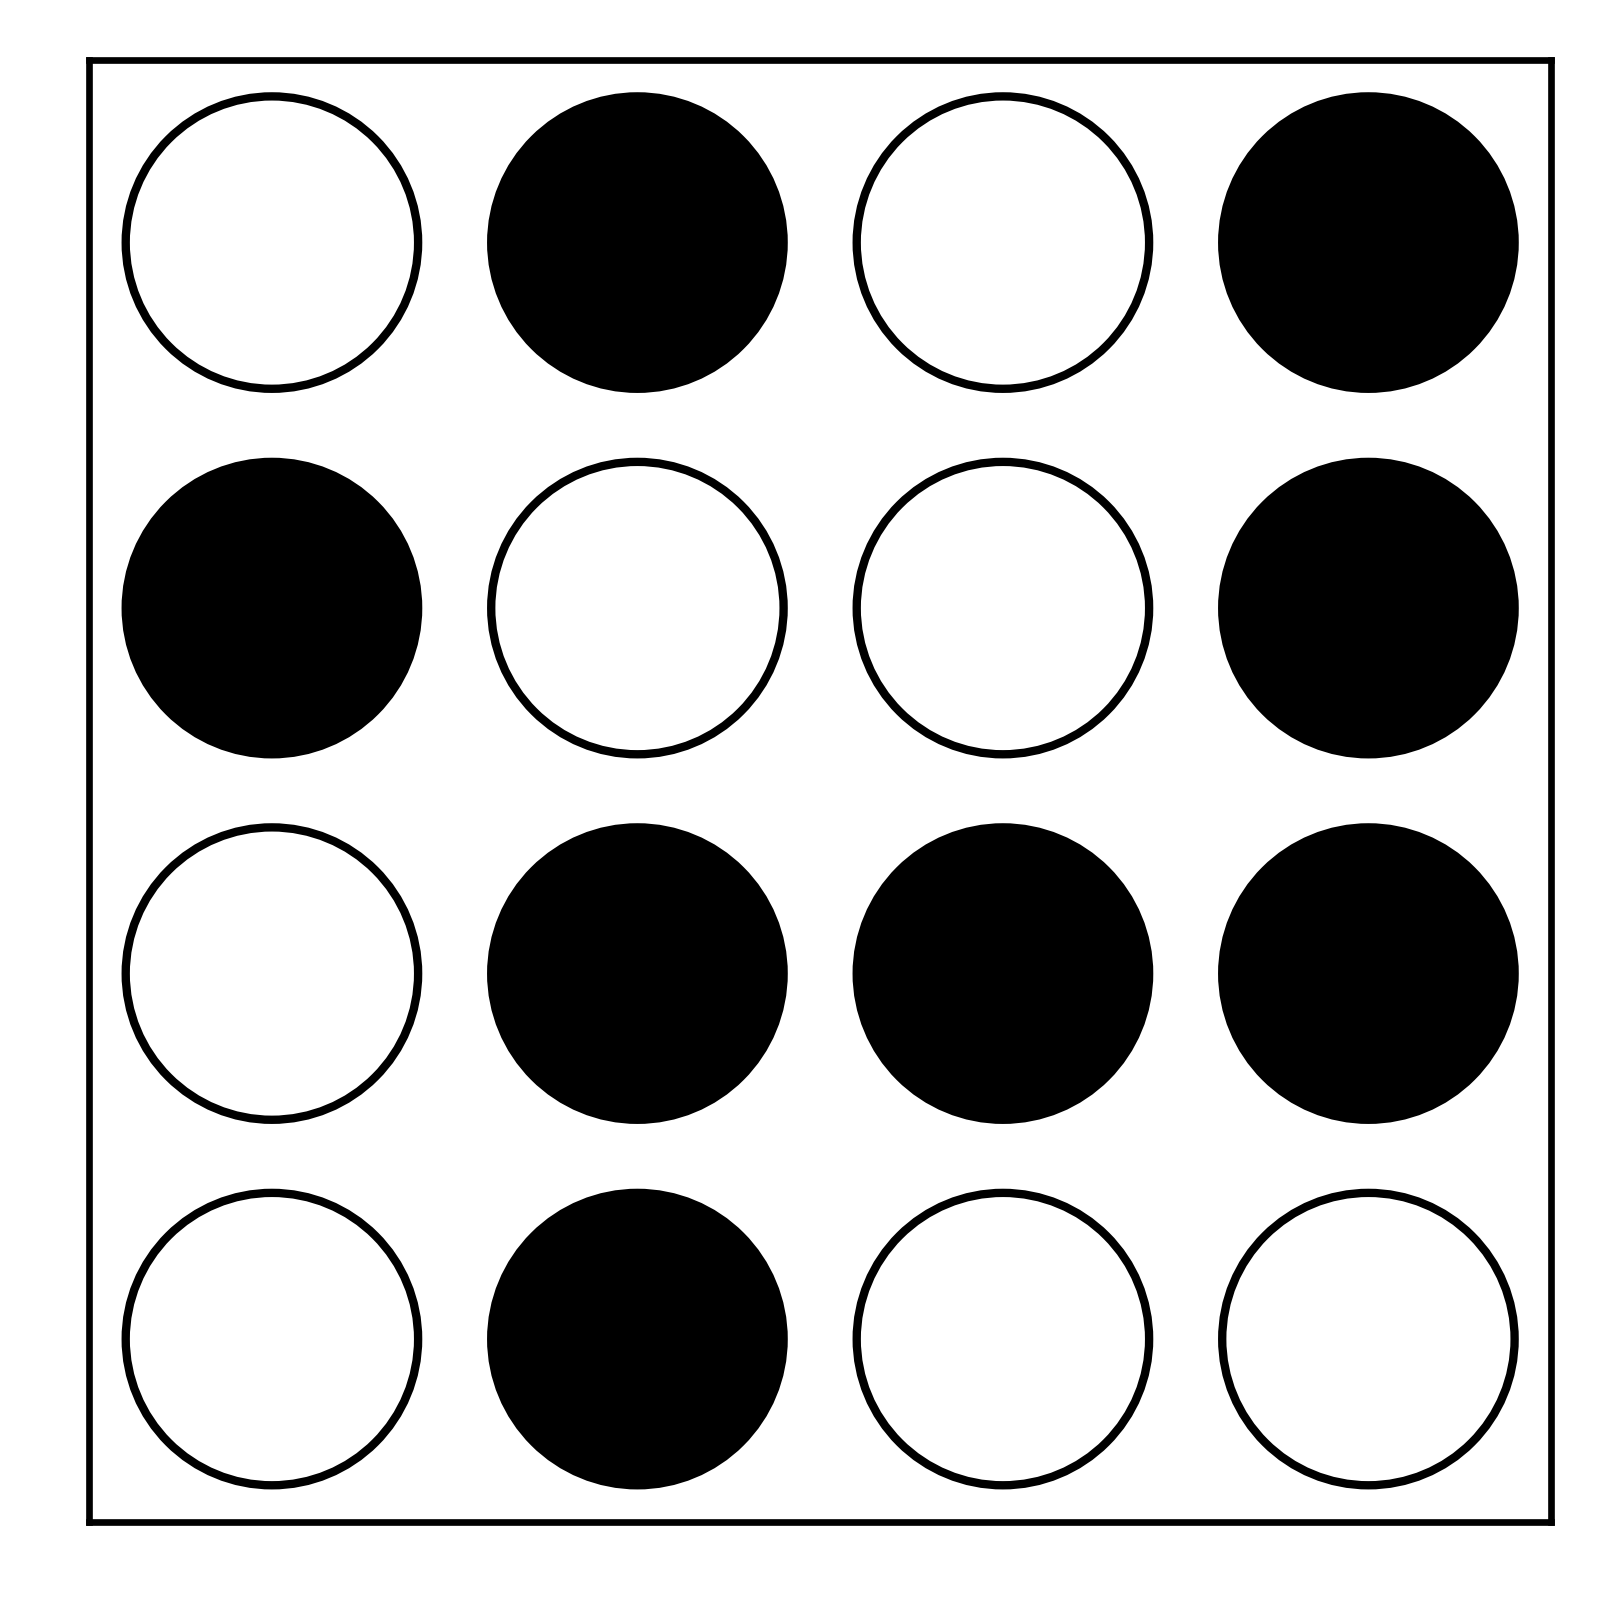

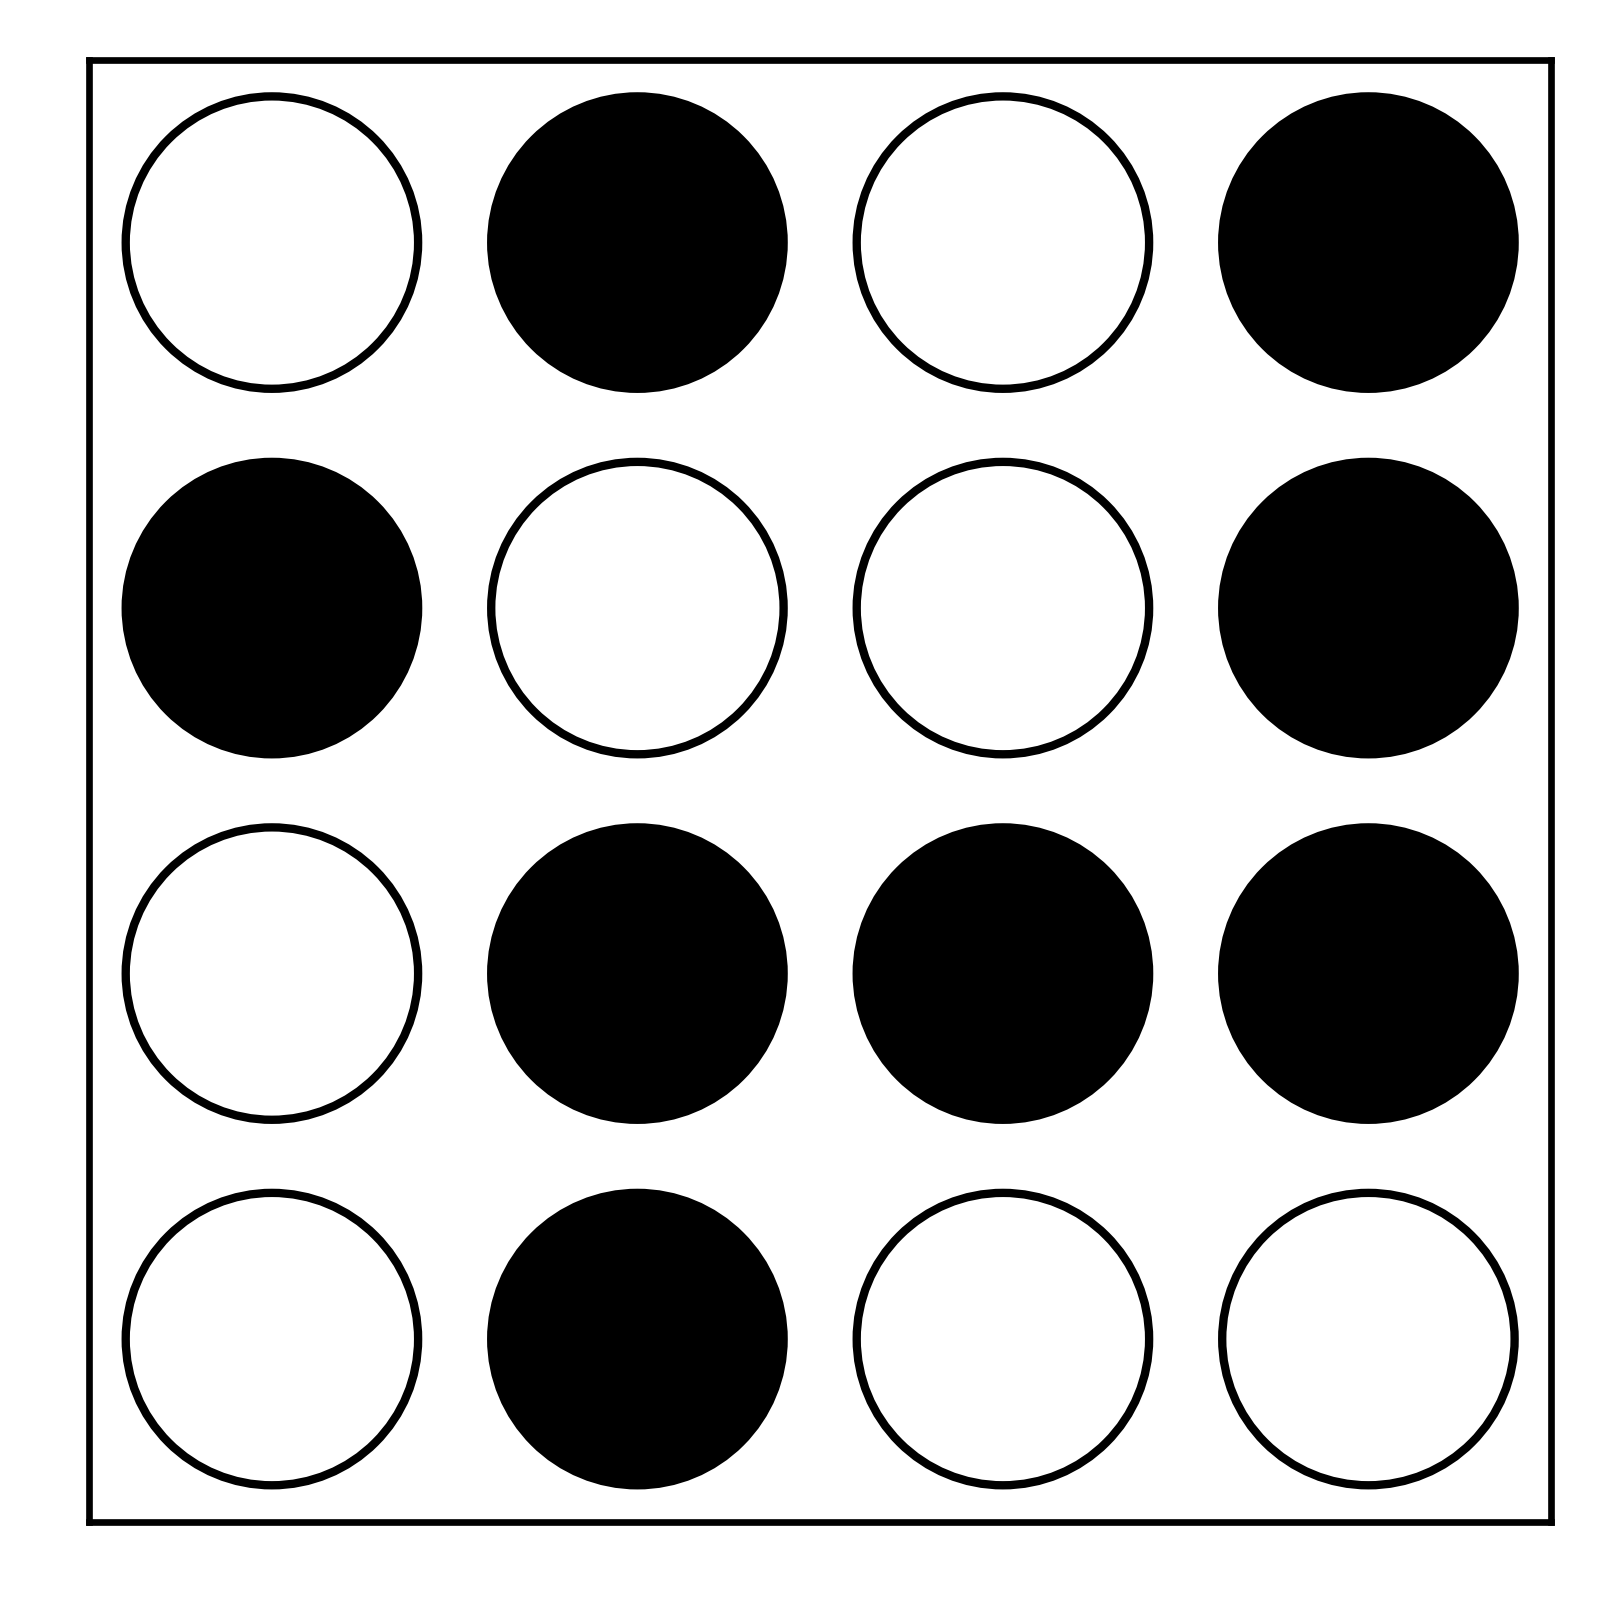

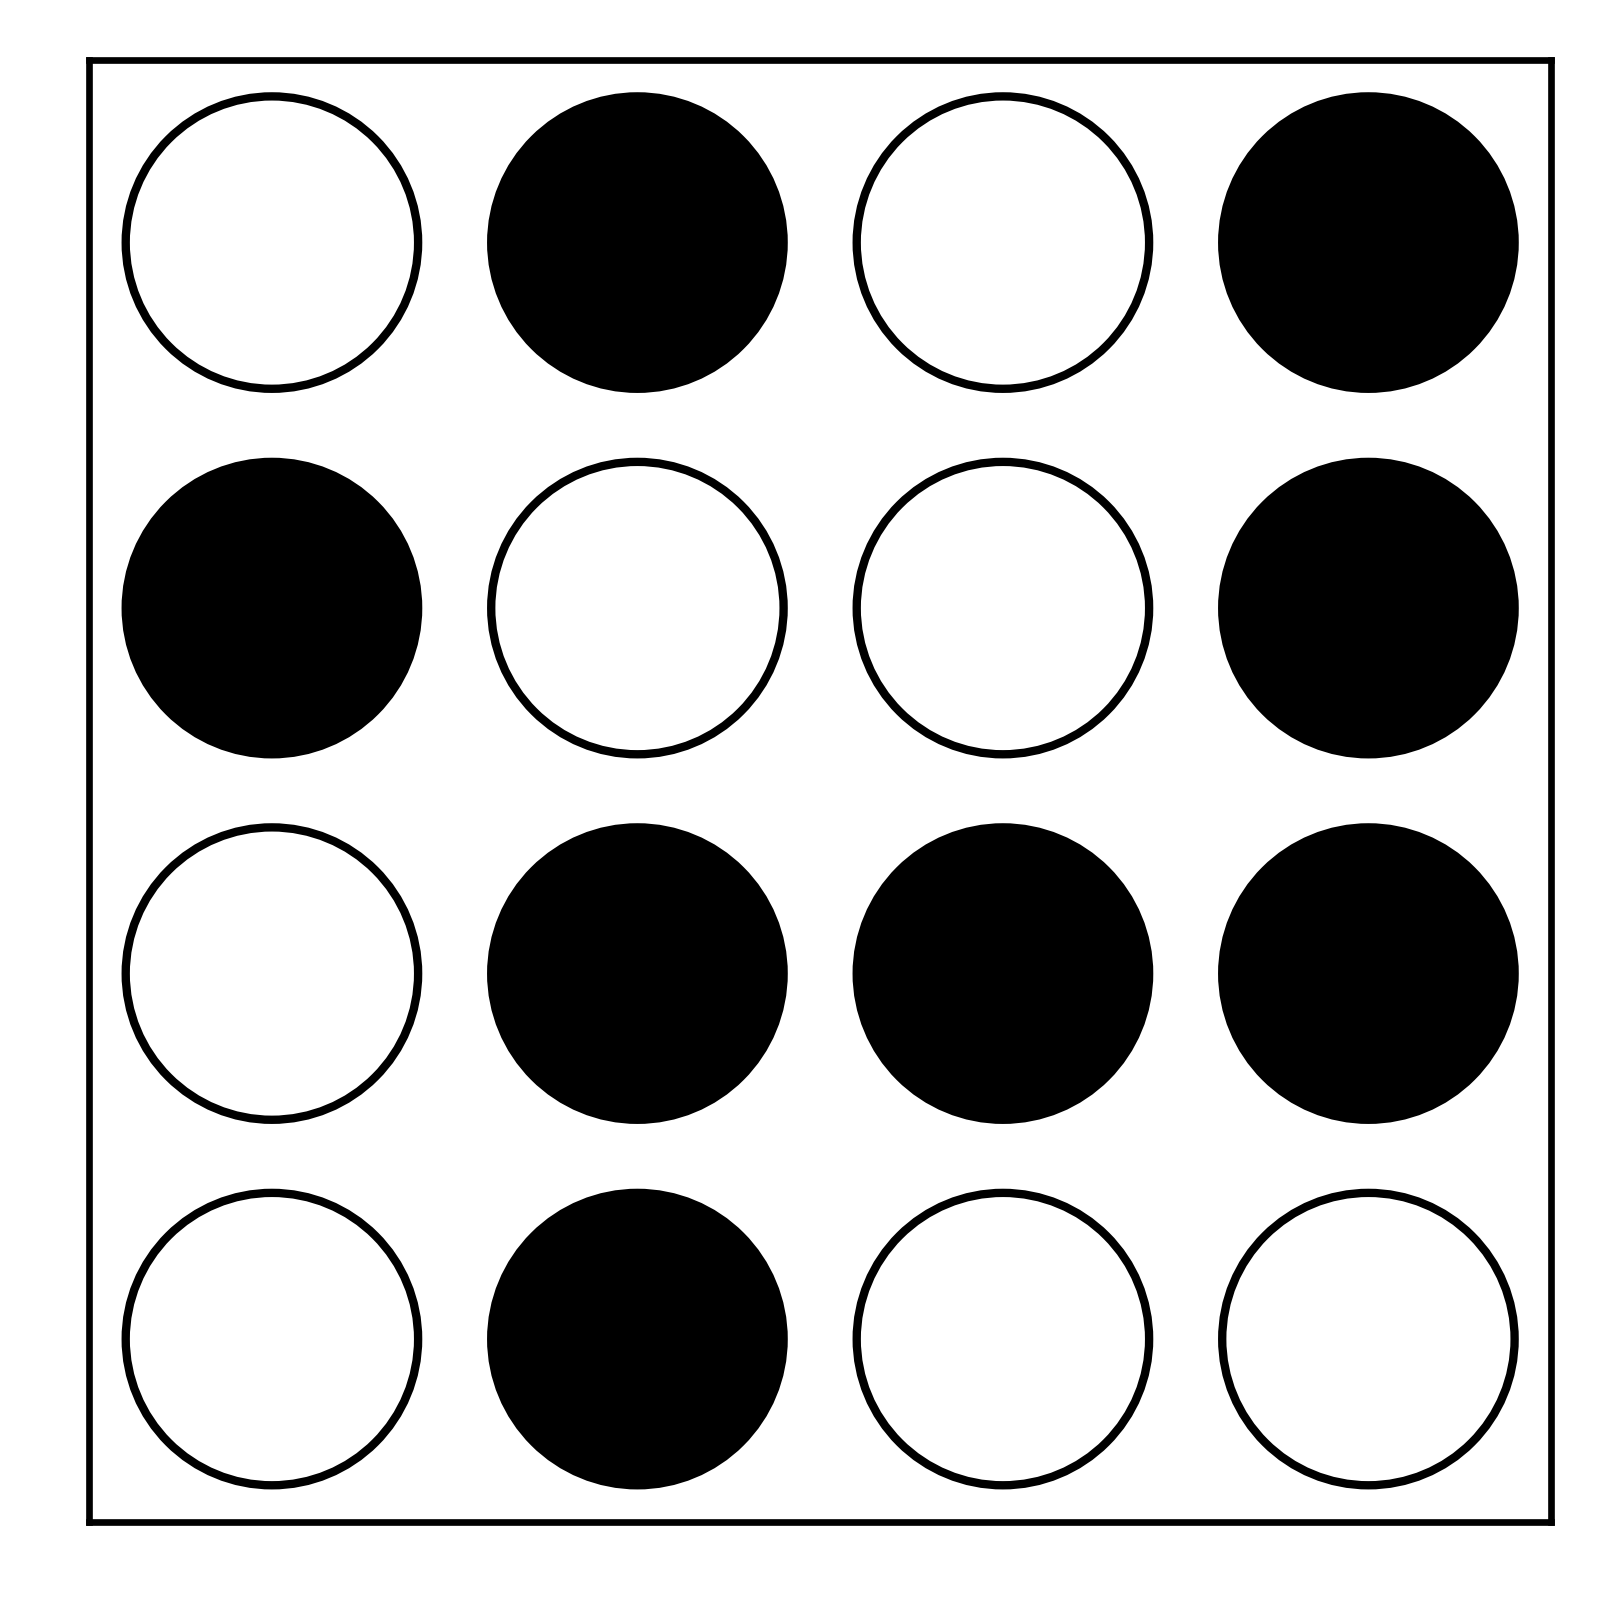

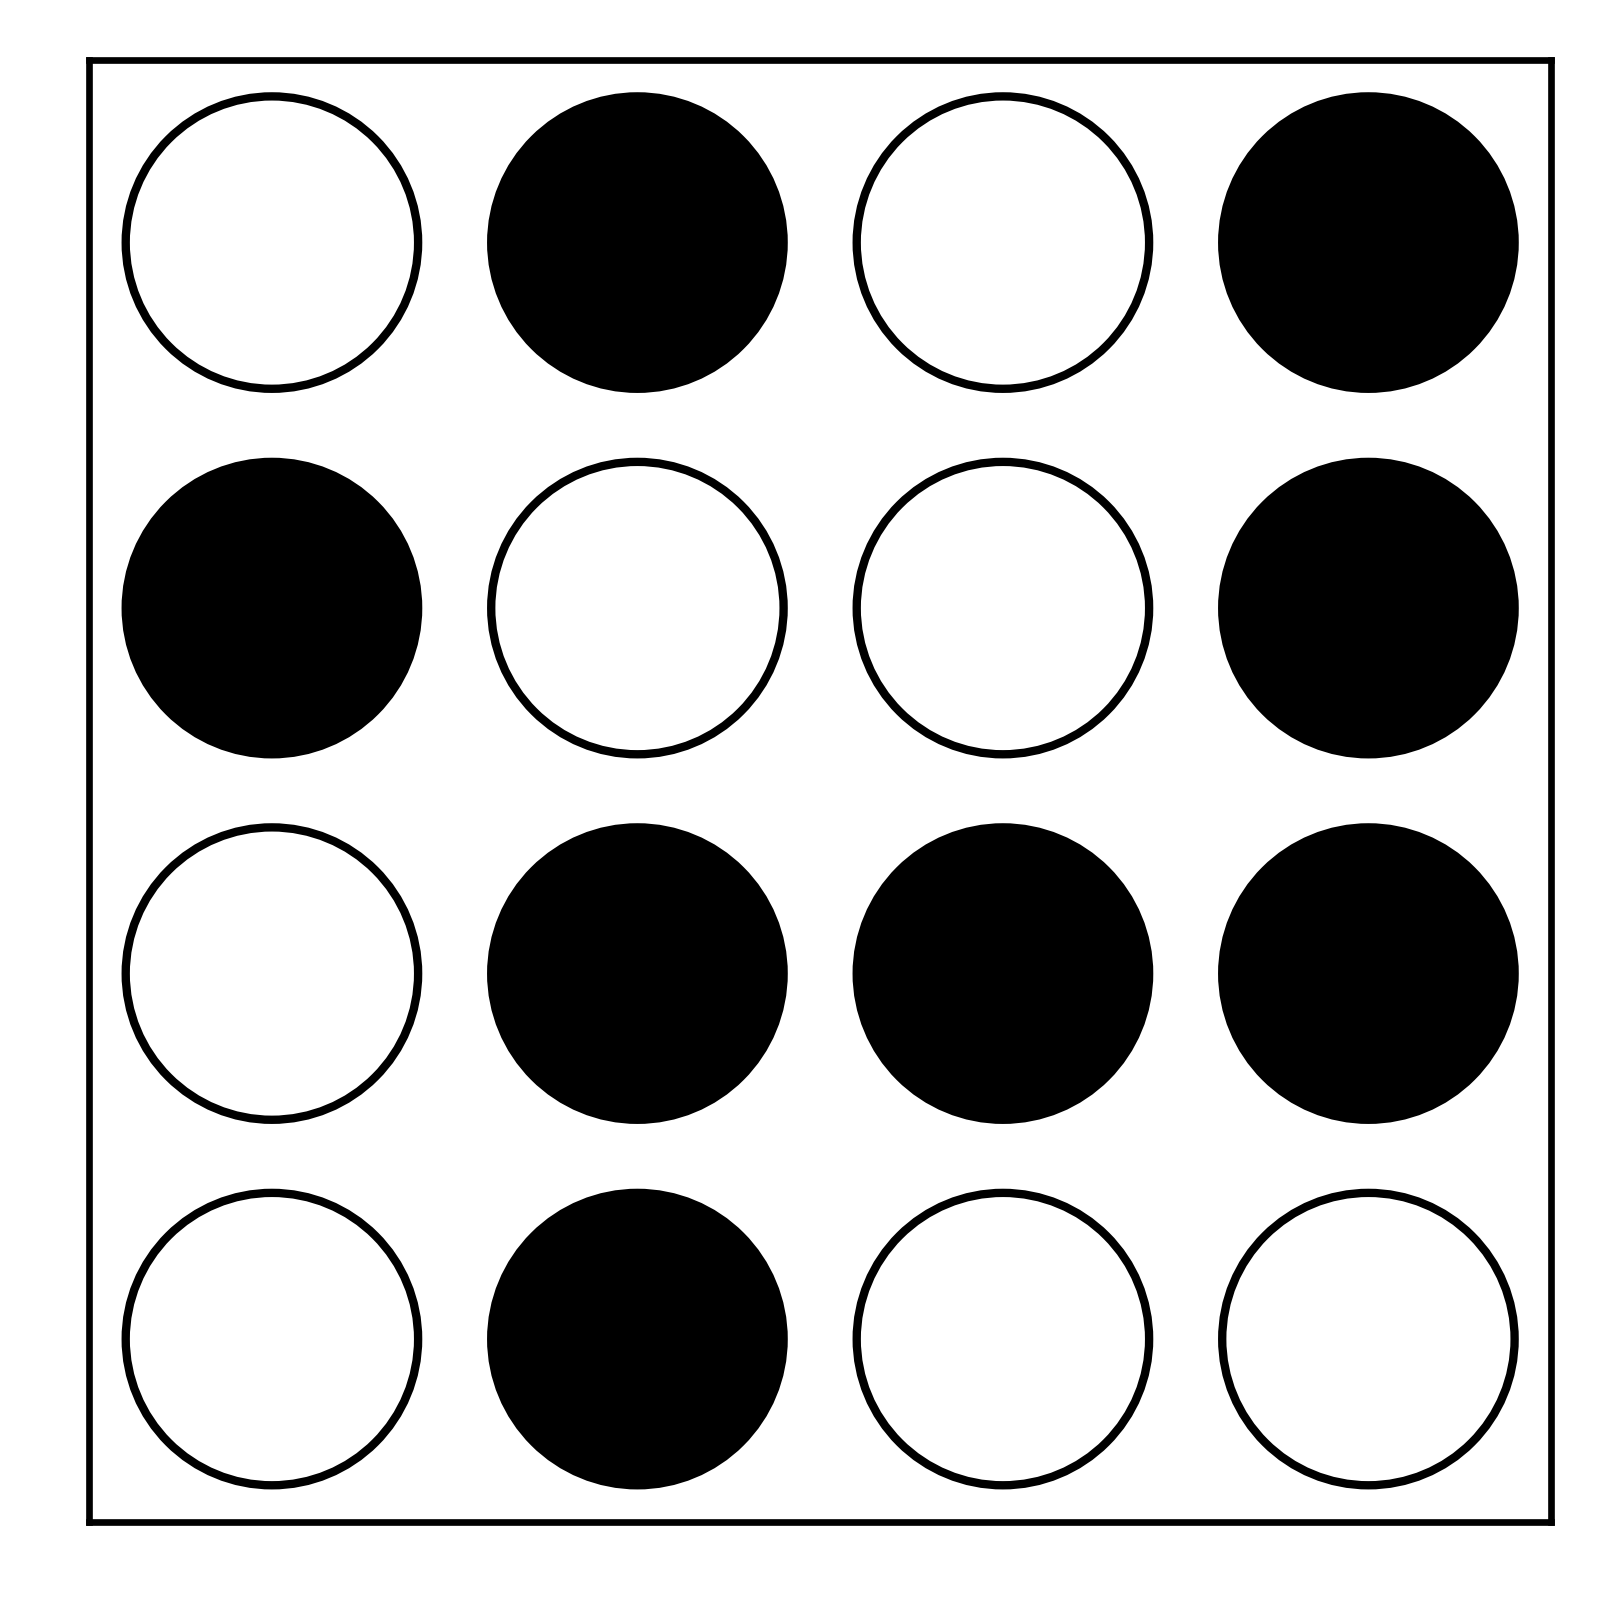

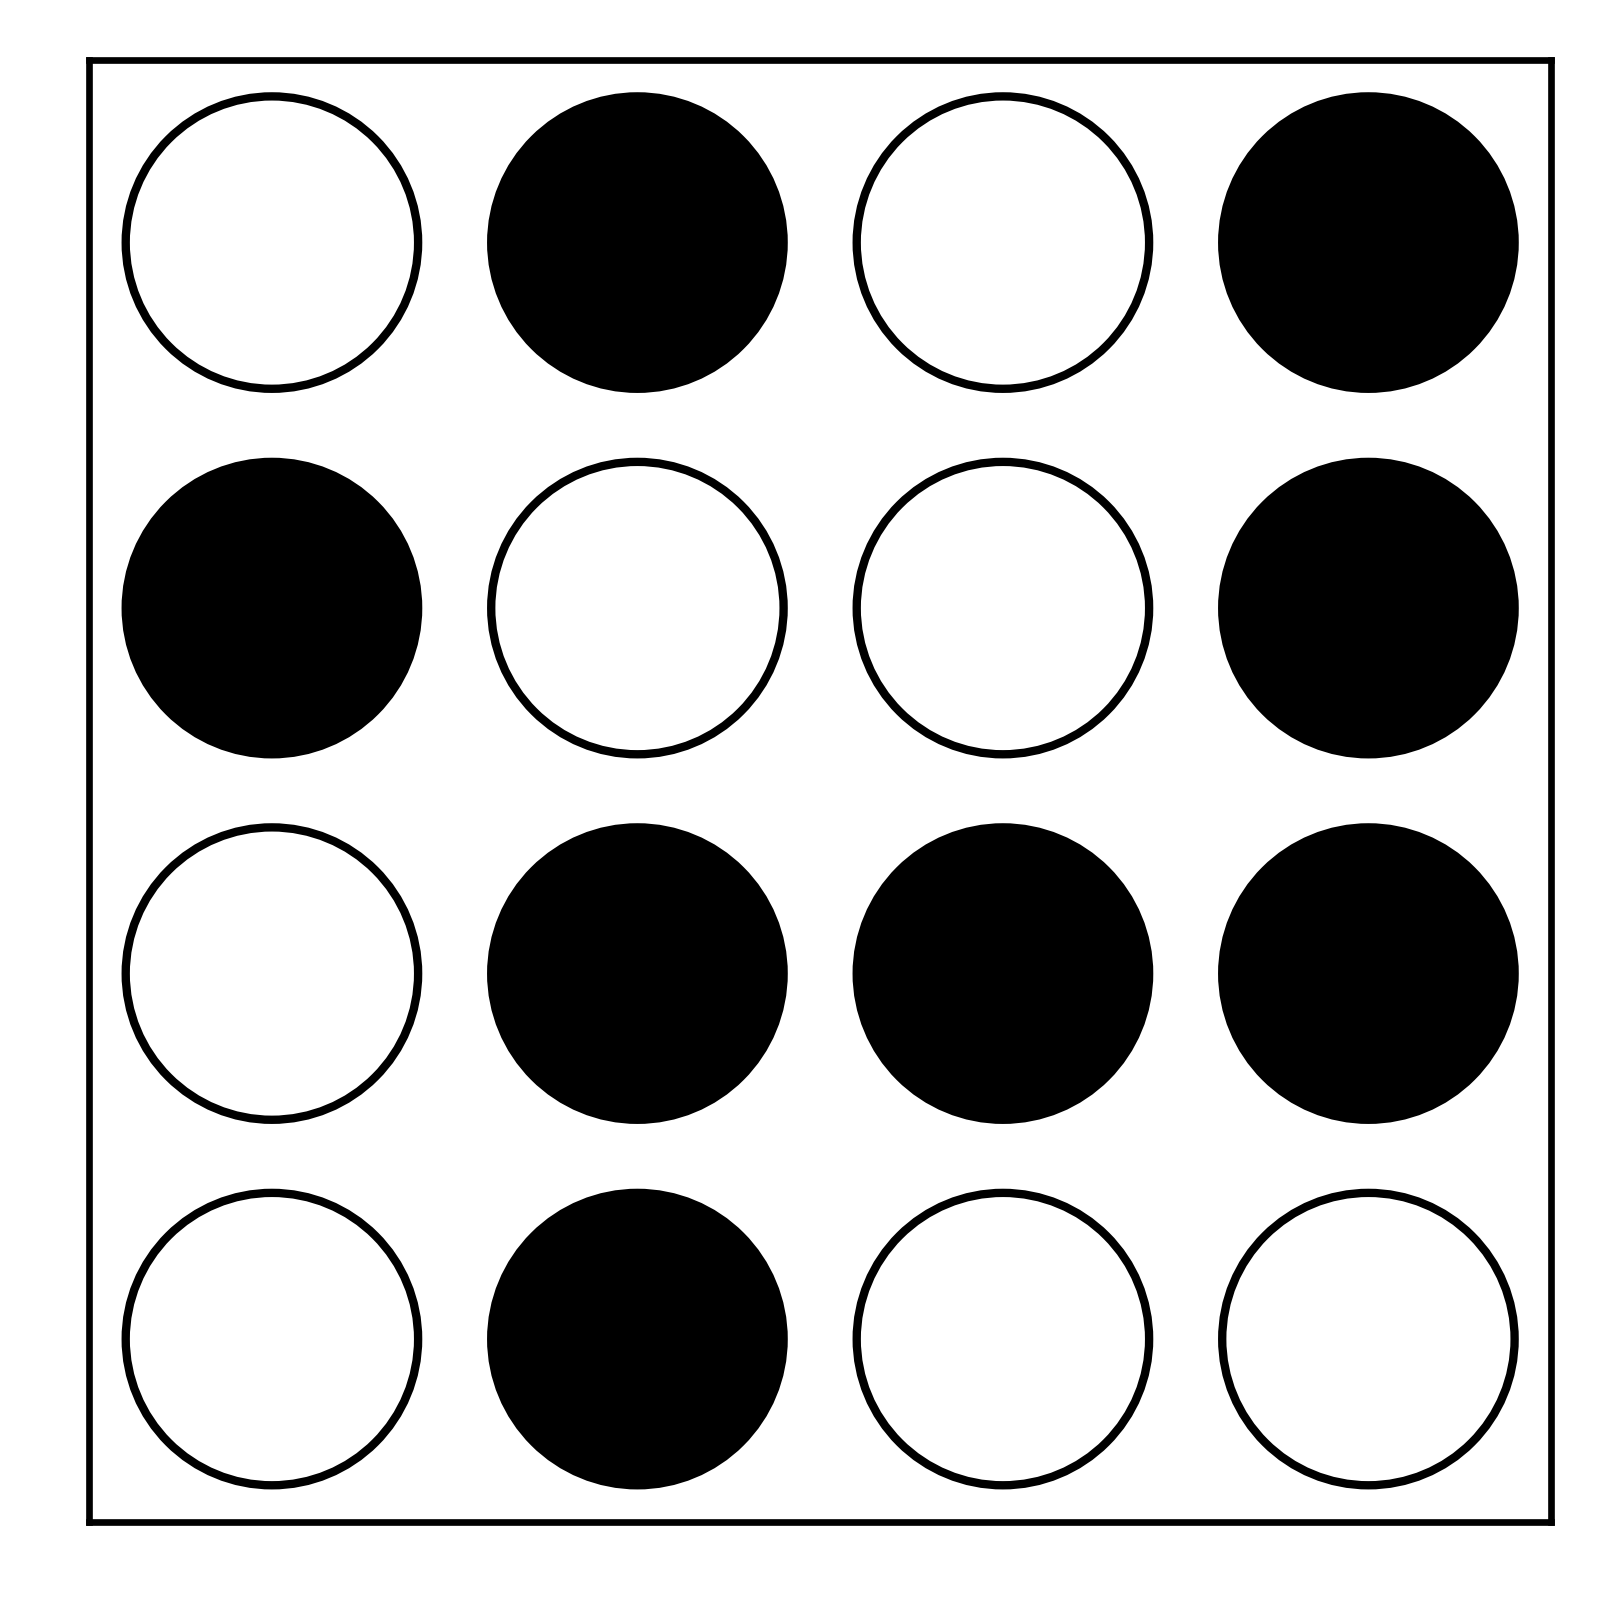

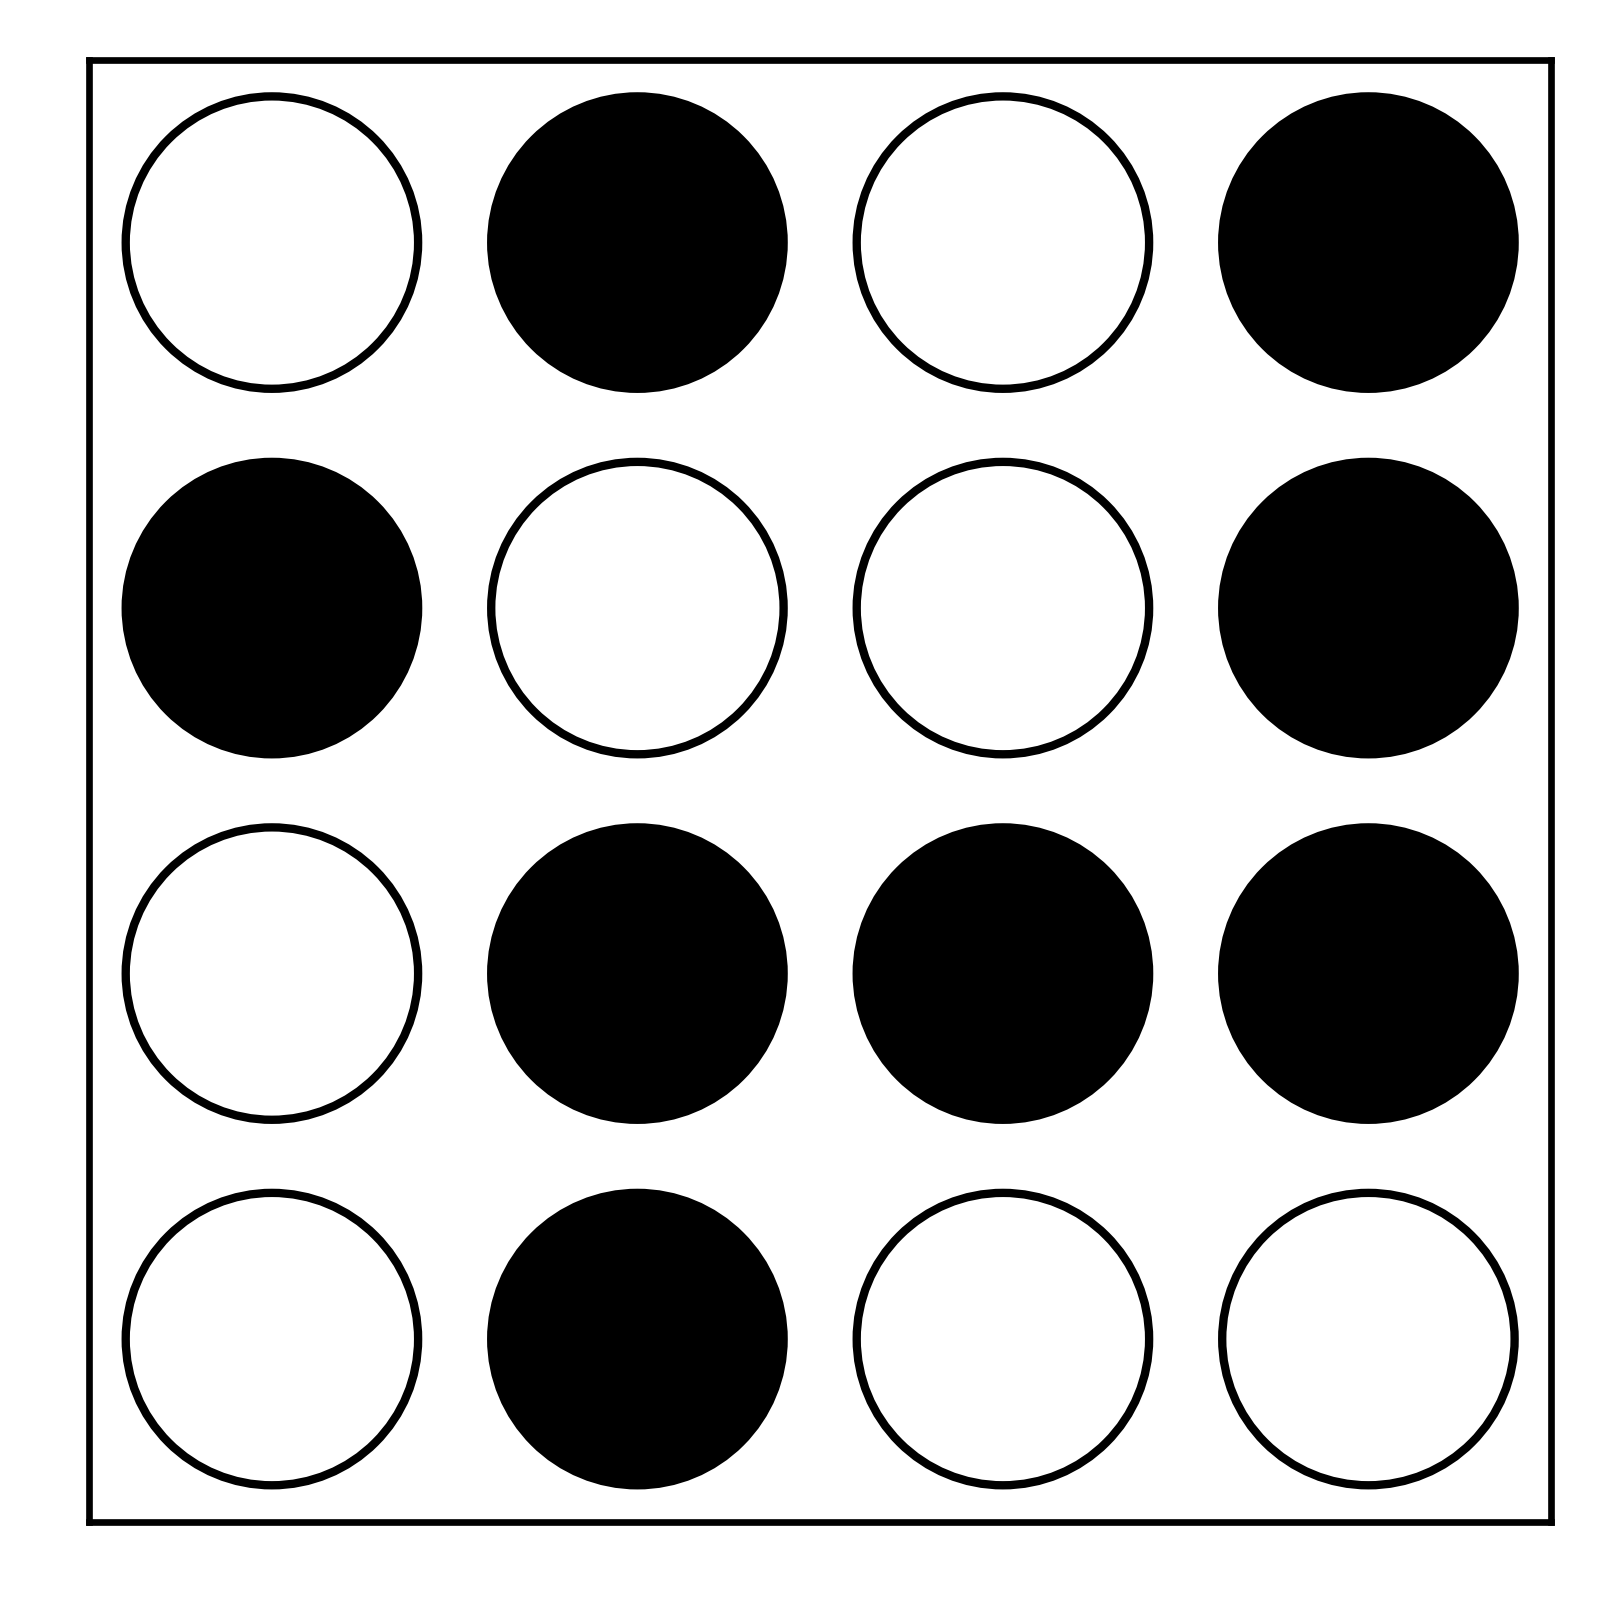

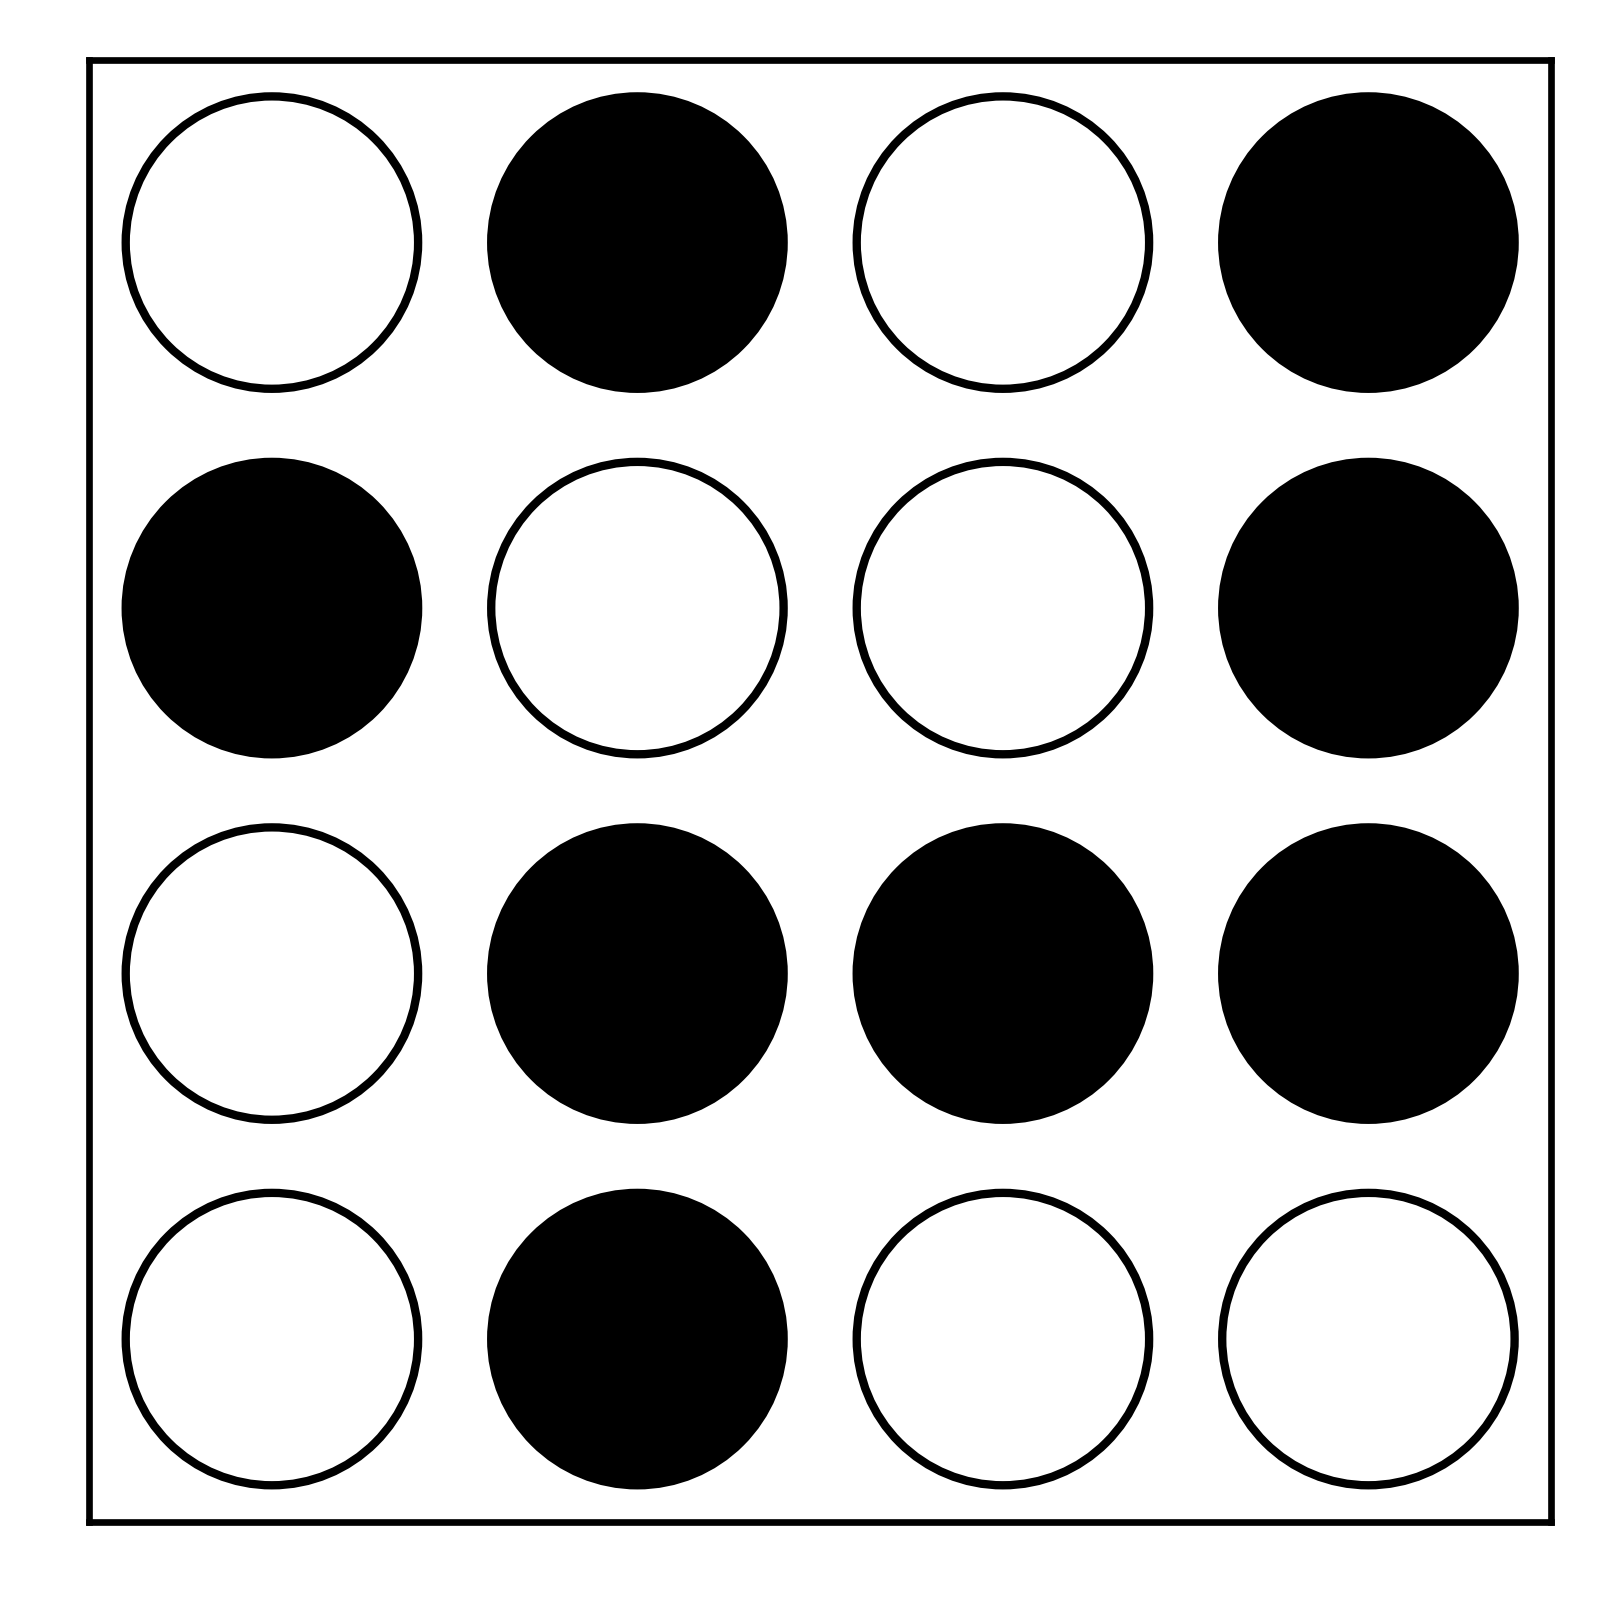

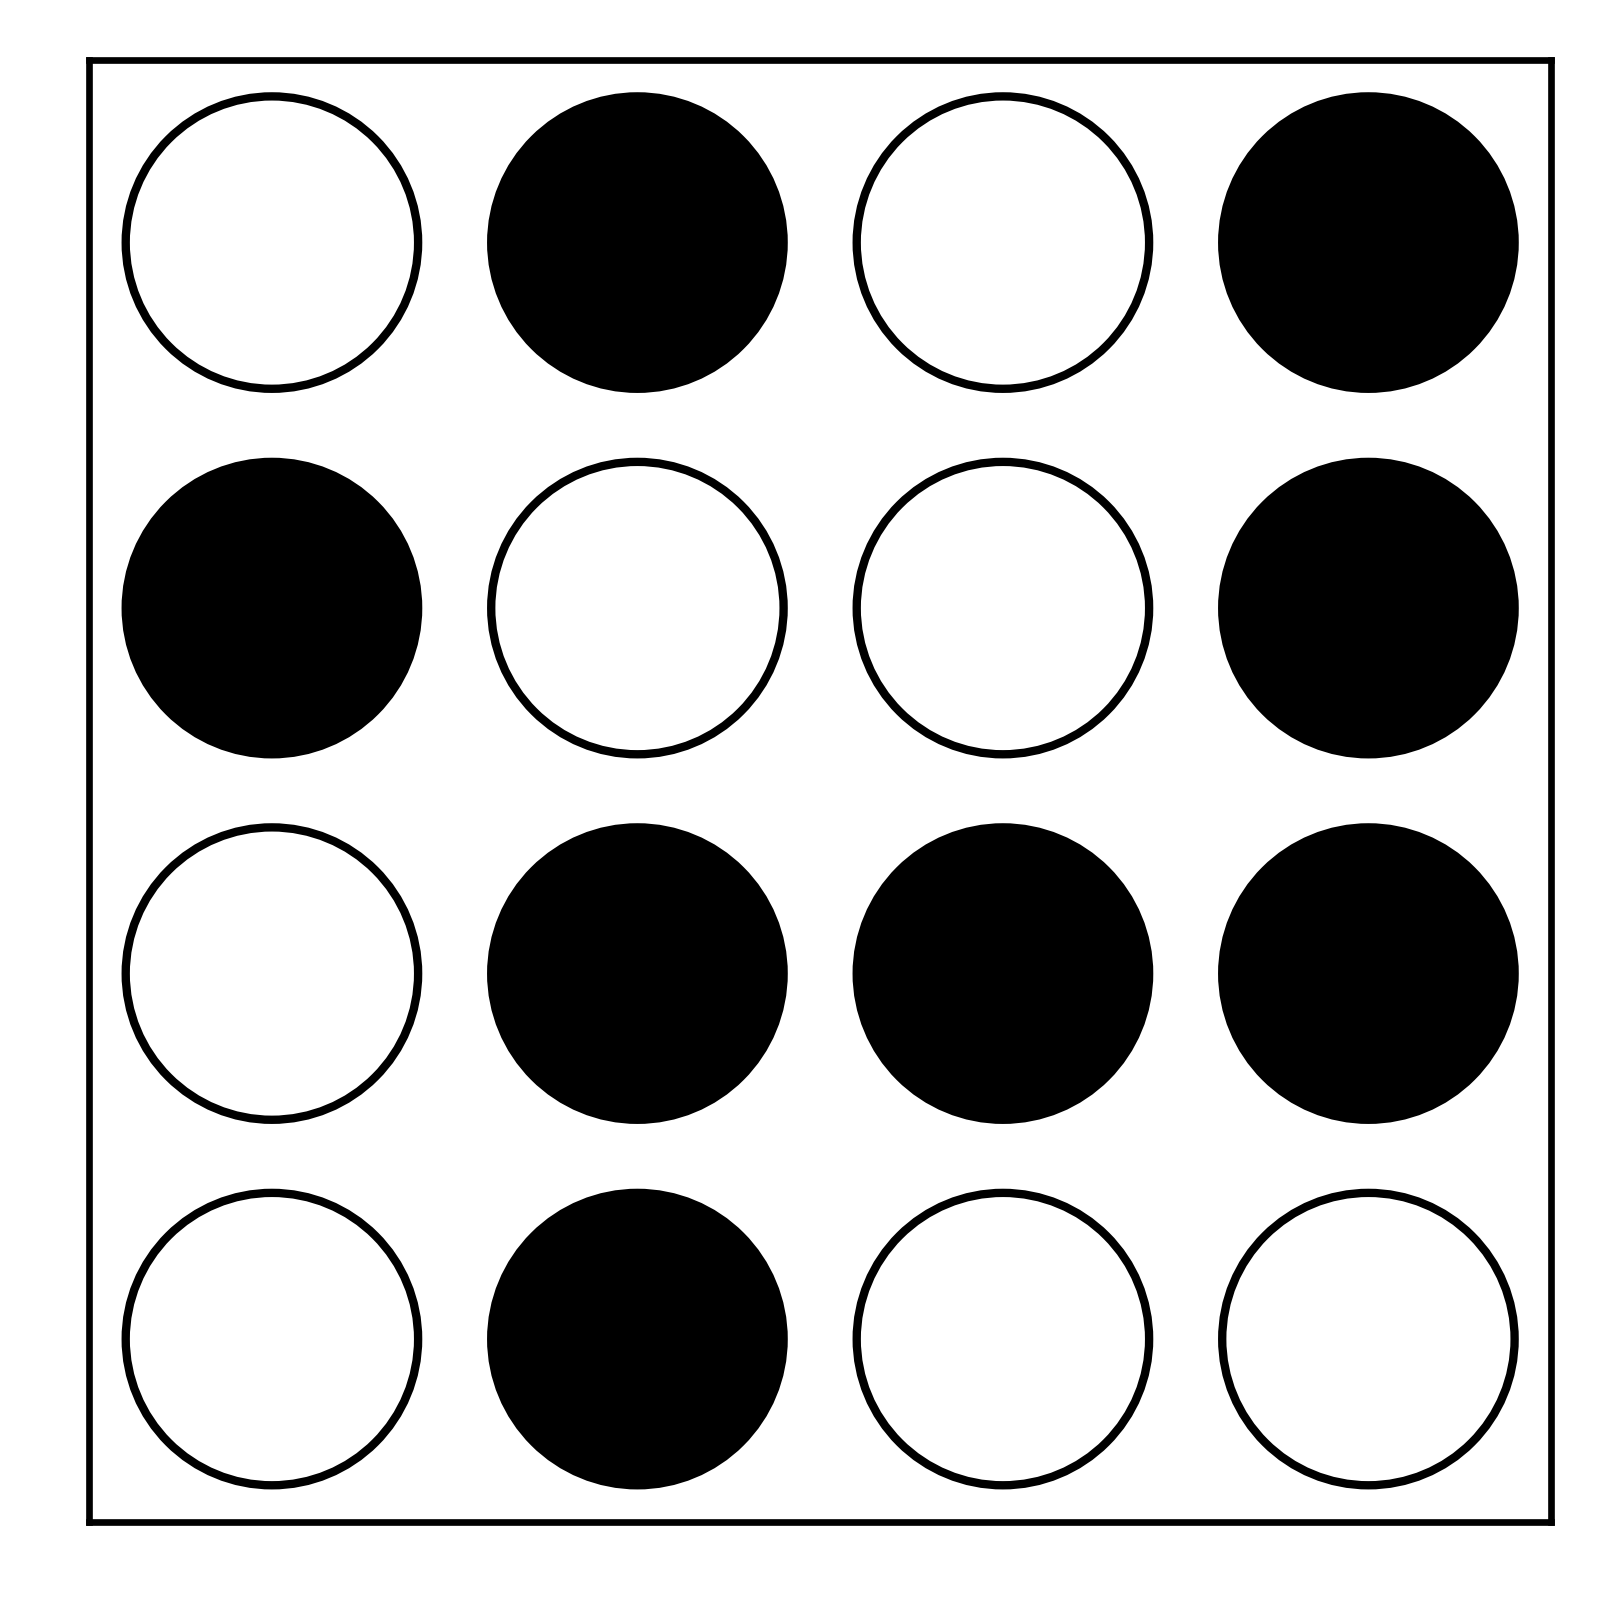

In [76]:
all_energies = [] # list of lists
for i in range(1):
    energies = []
    obs = env.reset()
    lattice_init = env.state
    energies.append(env.compute_energy())
    plot_lattice(env.state)
    for i in range(65):
        action, _state = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        energies.append(env.compute_energy())
        plot_lattice(env.state)
        if done:
            break
            # env.reset()
        # if i % 100 == 0:
        #   print(f"{i=}, {reward=}")
        #   env.render()
    all_energies.append(energies)